<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/Surgical_VQA_GPT_BioGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# sentence-transformers by UKPLab (To classify text)
page: https://www.libhunt.com/r/sentence-transformers

github: https://github.com/UKPLab/sentence-transformers

In [5]:
!pip install -q sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.6 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
query = "I ate dinner"
query_vec = sbert_model.encode([query])[0]
print('Sample BERT embedding vector - length', len(query_vec))

Sample BERT embedding vector - length 768


# Image Feature Extraction

In [ ]:
import torch
from torchvision import models
num_classes = 12
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.eval();

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

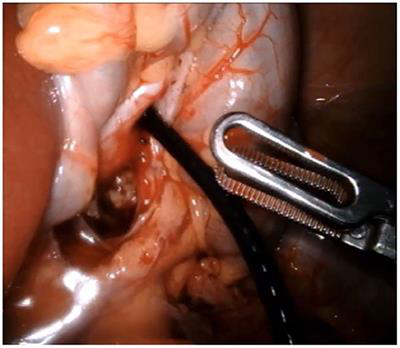

In [ ]:
from PIL import Image
import requests
url = 'https://www.frontiersin.org/files/MyHome%20Article%20Library/446547/446547_Thumb_400.jpg'
img = Image.open(requests.get(url, stream=True).raw)
img

In [ ]:
from torchvision import transforms
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

img_preprocessed = preprocess(img)
batch_img_tensor = torch.unsqueeze(img_preprocessed, 0)
new_fc = torch.nn.Sequential(*list(model.fc.children())[:-1])
model.fc = new_fc
img_features = model(batch_img_tensor)
print(img_features.shape)

torch.Size([1, 2048])


# VQA Surgery

Naive version

In [ ]:
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
from torchvision import models

labels = [ 'grasping', 'retraction', 'tissue manipulation', 'tool manipulation', 
          'cutting', 'cauterization', 'suction', 'looping', 'suturing', 'clipping', 'staple', 'ultrasound sensing']

class Surgical_VQA(nn.Module):
    def __init__(self, num_classes=12):
        super(Surgical_VQA, self).__init__()
        #self.num_classes = num_classes

        # text processing
        self.text_feature_extractor = SentenceTransformer('bert-base-nli-mean-tokens').cuda()
        # image processing
        self.img_feature_extractor = models.resnet50(pretrained=True)
        new_fc = nn.Sequential(*list(self.img_feature_extractor.fc.children())[:-1])
        self.img_feature_extractor.fc = new_fc

        #classifier
        self.classifier = nn.Linear(2816, num_classes)

    def forward(self, img, text):
        img_feature = self.img_feature_extractor(img)
        text_feature = self.text_feature_extractor.encode([text])[0]
        img_text_features = torch.cat((img_feature, torch.tensor(text_feature).unsqueeze(0).cuda()), dim=1)
        out = self.classifier(img_text_features)
        return out

text = "What is the state of bipolar_forceps?"
SVQA = Surgical_VQA(num_classes=12).cuda()
output = SVQA(batch_img_tensor.cuda(), text)
answer = output.argmax(dim=1)
print('Question: {} \nAnswer: {}'.format(text, labels[answer.item()]))

VQA: ChatGPT + ResNet

In [1]:
!pip -q install transformers

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms
from transformers import BertTokenizer, GPT2Model, GPT2Tokenizer
from PIL import Image
import requests

url = 'https://www.frontiersin.org/files/MyHome%20Article%20Library/446547/446547_Thumb_400.jpg'
img = Image.open(requests.get(url, stream=True).raw)
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

labels = [ 'grasping', 'retraction', 'tissue manipulation', 'tool manipulation', 
          'cutting', 'cauterization', 'suction', 'looping', 'suturing', 'clipping', 'staple', 'ultrasound sensing']
num_classes = 12
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.eval();

class GPT2RS18Classification(nn.Module):
    def __init__(self, num_class = 12):
        super(GPT2RS18Classification, self).__init__()

        # text processing
        self.text_feature_extractor = GPT2Model.from_pretrained('gpt2')
 
        # image processing
        self.img_feature_extractor = models.resnet18(pretrained=True)
        new_fc = nn.Sequential(*list(self.img_feature_extractor.fc.children())[:-1])
        self.img_feature_extractor.fc = new_fc

        #intermediate_layers
        self.intermediate_layer = nn.Linear(1280, 512)  #(512+768)
        self.LayerNorm = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.1)

        # classifier
        self.classifier = nn.Linear(512, num_class)

    def forward(self, input, img):
        
        # image encoder features
        img_feature = self.img_feature_extractor(img)
        
        # question tokenizer features
        input['input_ids'] = input['input_ids'].to(device)
        input['attention_mask'] = input['attention_mask'].to(device)

        # GPT text encoder
        text_feature = self.text_feature_extractor(**input)
        text_feature = text_feature.last_hidden_state.swapaxes(1,2)
        text_feature = F.adaptive_avg_pool1d(text_feature,1)
        text_feature = text_feature.swapaxes(1,2).squeeze(1)        
        
        # late visual-text fusion
        img_text_features = torch.cat((img_feature, text_feature), dim=1)

        # intermediate layers
        out =self.intermediate_layer(img_text_features)
        out = self.LayerNorm(out)
        out = self.dropout(out)

        # classifier
        out = self.classifier(out)
        print(out.size())
        return out


questions = "What is the state of bipolar_forceps?"
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

question = "What is the state of bipolar_forceps?"
questions = []
questions.append(question)
questions.append(question)
inputs = tokenizer(questions, padding=True, truncation=True, return_tensors="pt")

img_preprocessed = preprocess(img)
batch_img_tensor = torch.stack([img_preprocessed, img_preprocessed])
new_fc = torch.nn.Sequential(*list(model.fc.children())[:-1])
model.fc = new_fc
img_features = model(batch_img_tensor)

SVQA = GPT2RS18Classification(num_class=12).cuda()
output = SVQA(inputs, batch_img_tensor.cuda())
answer = output.argmax(dim=1)
print('Question: {} \nAnswer: {}'.format(questions[0], labels[answer[0].item()]))

torch.Size([2, 12])
Question: What is the state of bipolar_forceps? 
Answer: tool manipulation


VQA: BioGPT + ResNet<br>
src: https://huggingface.co/microsoft/biogpt<br>
git: https://github.com/microsoft/BioGPT<br>
paper: https://arxiv.org/abs/2210.10341<br>


In [8]:
!pip -q install transformers sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms
from transformers import BioGptTokenizer, BioGptForCausalLM
from transformers import BertTokenizer, GPT2Tokenizer
from PIL import Image
import requests
url = 'https://www.frontiersin.org/files/MyHome%20Article%20Library/446547/446547_Thumb_400.jpg'
img = Image.open(requests.get(url, stream=True).raw)
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

labels = [ 'grasping', 'retraction', 'tissue manipulation', 'tool manipulation', 
          'cutting', 'cauterization', 'suction', 'looping', 'suturing', 'clipping', 'staple', 'ultrasound sensing']
num_classes = 12
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.eval();

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class GPT2RS18Classification(nn.Module):
    def __init__(self, num_class = 12):
        super(GPT2RS18Classification, self).__init__()

        # text processing
        self.text_feature_extractor = BioGptForCausalLM.from_pretrained("microsoft/biogpt")
 
        # image processing
        self.img_feature_extractor = models.resnet18(pretrained=True)
        new_fc = nn.Sequential(*list(self.img_feature_extractor.fc.children())[:-1])
        self.img_feature_extractor.fc = new_fc

        #intermediate_layers
        self.intermediate_layer = nn.Linear(42896, 512)  #(512+768)
        self.LayerNorm = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.1)

        # classifier
        self.classifier = nn.Linear(512, num_class)

    def forward(self, input, img):
        
        # image encoder features
        img_feature = self.img_feature_extractor(img)
        
        # question tokenizer features
        input['input_ids'] = input['input_ids'].to(device)
        input['attention_mask'] = input['attention_mask'].to(device)

        # GPT text encoder
        text_feature = self.text_feature_extractor(**input)
        text_feature = text_feature[0].swapaxes(1,2)
        #mobarak: [1, 12, 42384], text feature is too big compare to img. We may pool it to 512 the equal size of img
        #F.adaptive_avg_pool2d(output[0],[1, 512])
        text_feature = F.adaptive_avg_pool1d(text_feature,1) 
        text_feature = text_feature.swapaxes(1,2).squeeze()

        # late visual-text fusion
        img_text_features = torch.cat((img_feature, text_feature), dim=1)

        # intermediate layers
        out =self.intermediate_layer(img_text_features)
        #mobarak: we may add one more intermidiate layer if the features size is bigger
        out = self.LayerNorm(out)
        out = self.dropout(out)

        # classifier
        out = self.classifier(out)
        print(out.size())
        return out



tokenizer = BioGptTokenizer.from_pretrained("microsoft/biogpt")
tokenizer.pad_token = tokenizer.eos_token

question = "What is the state of bipolar_forceps?"
questions = []
questions.append(question)
questions.append(question)
inputs = tokenizer(questions, padding=True, truncation=True, return_tensors="pt")

img_preprocessed = preprocess(img)
batch_img_tensor = torch.stack([img_preprocessed, img_preprocessed])
new_fc = torch.nn.Sequential(*list(model.fc.children())[:-1])
model.fc = new_fc
img_features = model(batch_img_tensor)

SVQA = GPT2RS18Classification(num_class=12).cuda()
output = SVQA(inputs, batch_img_tensor.cuda())
answer = output.argmax(dim=1)
print('Question: {} \nAnswer: {}'.format(questions[0], labels[answer[0].item()]))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

torch.Size([2, 12])
Question: What is the state of bipolar_forceps? 
Answer: cauterization
